In [91]:
import csv
import sys
import os
import pickle
import random
import numpy as np
import time
import operator
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

from collections import Counter

from scipy.stats import entropy
from scipy.stats import spearmanr
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity

In [92]:
sys.path.append('../python')
from permutation import permutation, compute_alignment_strength
from utils.utils_funcs import aggregate_embeddings_visual_and_language, get_variance, get_distinctness_from_nearest_5
from utils.utils_funcs import load_data_to_dict

In [93]:
def get_alignment_strength(struct,concepts,relative):
    visual_embeddings_list=list()
    langauge_embeddings_list=list()
    for concept in concepts:
        embeddings=struct["embeds"][concept]
        visual_embeddings_list.append(embeddings["visual"])
        langauge_embeddings_list.append(embeddings["language"])
    z_0=np.array(visual_embeddings_list)
    z_1=np.array(langauge_embeddings_list)
    if relative:
        return permutation(z_0,z_1,n_sim=100)[0]
    else:
        return compute_alignment_strength(z_0,z_1)

In [94]:
def percent_lower(var,lst):
    return sum(1 if i < var else 0 for i in lst)/len(lst)

In [95]:
def get_avg(concepts,var_dict):
    var_list=list()
    for concept in concepts:
        if concept in var_dict:
            var_list.append(var_dict[concept])
    if var_list:
        return round(np.mean(var_list),4)
    else:
        return 0

In [96]:
vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_concept_least20_swav_bert_20.pkl","rb"))
vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_concept_least20_swav_bert_20.pkl","rb"))

In [97]:
aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [98]:
noun_visual_variance,noun_language_variance=get_variance(vg_noun_data)
verb_visual_variance,verb_language_variance=get_variance(vg_verb_data)

In [99]:
noun_visual_distinctness,noun_language_distinctness=get_distinctness_from_nearest_5(vg_noun_data)
verb_visual_distinctness,verb_language_distinctness=get_distinctness_from_nearest_5(vg_verb_data)

In [100]:
noun_freq_dict=load_data_to_dict("../data/processed/childes_noun_freq.txt",header=True)
verb_freq_dict=load_data_to_dict("../data/processed/childes_verb_freq.txt",header=True)

In [101]:
noun_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_noun_aoa.txt",concepts=vg_noun_data["words"])
verb_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_verb_aoa.txt",concepts=vg_verb_data["words"])

noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [102]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [103]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

<AxesSubplot:ylabel='Density'>

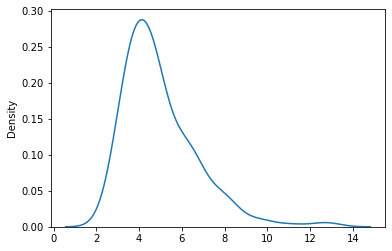

In [104]:
sns.kdeplot([i[1] for i in noun_aoa_sorted])

In [105]:
# cooccurence_data=pickle.load(open("../data/processed/dumped/verb_cooccurence_visual.pkl","rb"))

In [106]:
# co_table=cooccurence_data["table"]
# co_nouns=cooccurence_data["nouns"]
# co_verbs=cooccurence_data["verbs"]

In [107]:
# co_bi_table=np.zeros(co_table.shape)
# for i,row in enumerate(co_table):
#     for j,cell in enumerate(row):
#         if cell:
#             co_bi_table[i][j]=1
#         else:
#             co_bi_table[i][j]=0

In [108]:
# heaviness_list=np.sum(co_bi_table,axis=1)
# heaviness=dict()
# for i,verb in enumerate(co_verbs):
#     concept=verb.split(".")[0]
#     if concept in vg_verb_data["words"]:
#         heaviness[concept]=heaviness_list[i]
# heaviness_sorted= sorted(heaviness.items(), key=operator.itemgetter(1))

In [109]:
# heaviness_sorted

In [110]:
def compute_percentage_avg(concepts,shuffled_concepts,dic):
    num_list=list()
    for sh_concepts in shuffled_concepts:
        num_list.append(get_avg(sh_concepts,dic))
    # print("!!:",num_list,get_avg(concepts,dic))
    return get_avg(concepts,dic)-np.mean(num_list)
    #return percent_lower(get_avg(concepts,dic),num_list)

In [111]:
def compute_percentage_alignment(concepts,shuffled_concepts,struct,relative):
    num_list=list()
    for sh_concepts in shuffled_concepts:
        num_list.append(get_alignment_strength(struct,sh_concepts,relative))
    # print(concepts)
    # print(num_list)
    # print(get_alignment_strength(struct,concepts,relative))
    # print("-----------")
    return get_alignment_strength(struct,concepts,relative)-np.mean(num_list)
    #return percent_lower(get_alignment_strength(struct,concepts,relative),num_list)

In [112]:
def sim_percentage_in_order(struct,concepts,freq_dict,distinct_dict,variance_dict,
                            step=20,num_simulation=1000,concept_accum=True,relative=False):
    
    xs=list()
    alignments=list()
    freqs=list()
    variances=list()
    distincts=list()

    for idx in range(0,len(concepts),step):
        if concept_accum:
            concept_group=concepts[:idx+step]
        else:
            concept_group=concepts[idx:idx+step]
        
        # if len(concept_group)!=step:
        #     continue
            
        # print(len(concept_group))
        
        shuffled_list=list()
        temp=concepts.copy()
        for i in range(num_simulation):
            random.shuffle(temp)
            temp2=temp[:len(concept_group)]
            shuffled_list.append(temp2)
            # print(sorted(temp2))
            # for j in temp2:
            #     if j not in concept_group:
            #         print(j)
        
        xs.append(min(idx+step,len(concepts)))
        alignments.append(compute_percentage_alignment(concept_group,shuffled_list,struct,relative))
        freqs.append(compute_percentage_avg(concept_group,shuffled_list,freq_dict))
        variances.append(compute_percentage_avg(concept_group,shuffled_list,variance_dict))
        distincts.append(compute_percentage_avg(concept_group,shuffled_list,distinct_dict))
    
    return alignments,freqs,variances,distincts,xs

In [113]:
def plot_percentage_in_order(title,struct,concepts,freq_dict,distinct_dict,variance_dict,
                            step=20,num_simulation=1000,concept_accum=True,relative=False):
    t1=time.time()
    alignments,freqs,variances,distincts,xs=sim_percentage_in_order(struct,concepts,freq_dict,distinct_dict,variance_dict,
                            step,num_simulation,concept_accum,relative)
    t2=time.time()
    print(t2-t1)
    print(xs)
    print("alignment:",alignments)
    print("frequency:",freqs)
    print("variance:",variances)
    print("distinctness:",distincts)
    plt.plot(xs,alignments,color="green",label="Alignment Strength")
    plt.plot(xs,freqs,color="red",label="Frequency")
    plt.plot(xs,variances,color="purple",label="Variance")
    plt.plot(xs,distincts,color="blue",label="Distinctness")
    plt.title(title)
    plt.xlabel("number of concepts in the system")
    plt.ylabel("percentage")
    plt.legend()
    #plt.legend(["Alignment Strength","Frequency","Variance","Distinctness"])   

0.8697421550750732
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 207]
alignment: [-0.2671185770750988, -0.19321739130434784, 0.2908115942028984, -0.08759683794466402, -0.3190856389986825, 0.27798023715415016, 0.027046113306982866, 0.036810276679841825, 0.2719776021080369, 0.16896969696969694, -0.32335177865612647, 0.2800724637681159, 0.24988274044795783, 0.2525164690382082, 0.112433465085639, 0.33254018445322786, 0.018826086956521715, -0.12072990777338602, 0.05423978919631098, -0.11073254281949935, 0.4312077922077922]
frequency: [2853.206473, 1744.327694, 2454.1891119999996, 1419.2075, 1861.7956669999994, 2465.5767760000003, 1150.5555289999998, 461.6207790000003, 327.4287780000004, 435.3872219999994, -1249.2677760000001, -1218.9027780000001, -1498.1990270000001, 1223.289554, -1874.8428880000001, -1696.0463340000001, -1625.5942230000003, -2116.1826680000004, -2162.2752739999996, -2101.4154169999997, -2231.1528590000003]
variance: [2.0003471,

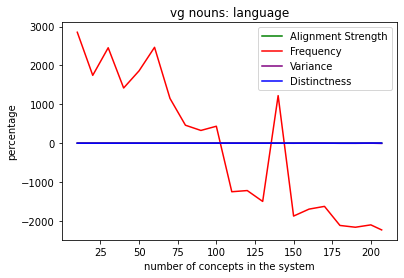

In [115]:
plot_percentage_in_order("vg nouns: language",aggregated_vg_noun_data,list(list(zip(*noun_aoa_sorted))[0]),noun_freq_dict,noun_language_distinctness,noun_language_variance,step=10,num_simulation=100,concept_accum=False,relative=False)

60.714617013931274
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 207]
alignment: [-0.38249999999999995, 0.12190000000000001, 0.15499999999999992, -0.04799999999999982, 0.2497999999999999, -0.13579999999999992, -0.07799999999999996, -0.4463, -0.1422, 0.36860000000000004, 0.28549999999999986, 0.3073, 0.2269, 0.02749999999999997, 0.3151999999999999, 0.26450000000000007, -0.32030000000000036, -0.012699999999999934, -0.4084000000000001, -0.1630000000000001, 0.13669999999999993]
frequency: [11055.020250999998, 3123.0664850000003, 15407.078768, 1381.30051, 2015.7588700000006, 477.17278499999884, -11.432189999999082, 3070.1693959999993, -1547.4861770000007, -2904.871927000001, -3022.1652180000006, -3437.6641299999997, -3557.8487590000004, -3861.4874879999993, -4090.2879590000002, -3846.8484329999997, -3431.9382049999995, -4577.881165, -3763.585492, -2972.841094, -4609.027739]
variance: [-1.0720978, 1.7019043, 2.6923027, 1.756012, 1.8294373, 3.57220

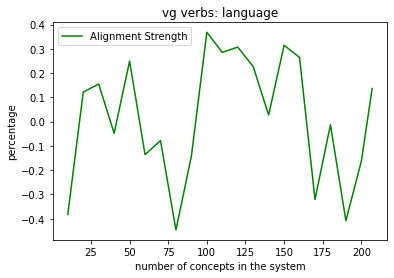

In [73]:
plot_percentage_in_order("vg verbs: language",aggregated_vg_verb_data,list(list(zip(*verb_aoa_sorted))[0]),verb_freq_dict,verb_language_distinctness,verb_language_variance,step=10,num_simulation=100,concept_accum=False,relative=True)

148.9377691745758
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
alignment: [-0.38930000000000003, 0.02760000000000018, 0.1593, 0.08765000000000012, 0.06359999999999999, 0.0766, 0.06120000000000014, 0.023350000000000093, 0.007749999999999924, 0.0]
frequency: [0.9, 0.925, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
variance: [0.0, 0.0, 0.0, 0.025, 0.05, 0.0, 0.1, 0.2, 0.3, 0.0]
distinctness: [1.0, 0.925, 0.975, 0.95, 0.95, 0.925, 0.7, 0.95, 0.575, 0.0]


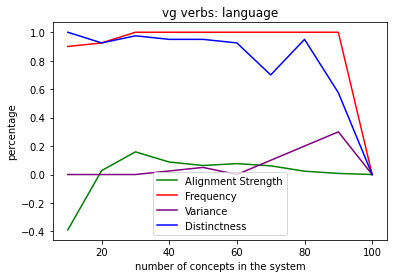

In [201]:
plot_percentage_in_order("vg verbs: language",aggregated_vg_verb_data,list(list(zip(*verb_aoa_sorted))[0])[:100],verb_freq_dict,verb_language_distinctness,verb_language_variance,step=10,num_simulation=40,concept_accum=True,relative=True)

In [65]:
# def gen_percentage_against_aoa_groups(struct,aoa_sorted,step,freq_dict,distinctness_dict,variance_dict,num_simulation=1000,concept_all=True):
#     alignment_z_score_list=list()
#     frequency_z_score_list=list()
#     distinctness_z_score_list=list()
#     variance_z_score_list=list()
    
#     aoa_list=list()
    
#     concept_group_all=list()
#     for idx in range(0,len(aoa_sorted),step):
#         concept_group=aoa_sorted[idx:idx+step]
#         concept_group_all.extend(concept_group)
#         if len(concept_group)!=step:
#             continue
#         if concept_all:
#             iterative=concept_group_all
#         else:
#             iterative=concept_group
#         aoa_list.append(idx+step)

#         #alignment strengh z score
#         alignment_strength_list=list()
#         aoa_set_alignment_strength=get_alignment_strength_of_true_mapping(struct,iterative)
#         alignment_strength_list.append(aoa_set_alignment_strength)
#         #frequency z score
#         frequency_list=list()
#         aoa_set_avg_freq=get_avg(iterative,freq_dict)
#         frequency_list.append(aoa_set_avg_freq)
#         #distinctness z score
#         distinct_list=list()
#         aoa_set_avg_distinct=get_avg(iterative,distinctness_dict)
#         distinct_list.append(1/aoa_set_avg_distinct)
#         #variance z score
#         variance_list=list()
#         aoa_set_avg_variance=get_avg(iterative,variance_dict)
#         variance_list.append(aoa_set_avg_variance)
        
#         shuffled_iterative=aoa_sorted.copy()
#         for _ in range(num_simulation):
#             random.shuffle(shuffled_iterative)
#             random_concepts=shuffled_iterative[:len(iterative)]
            
#             random_set_alignment_strength=get_alignment_strength_of_true_mapping(struct,random_concepts)
#             alignment_strength_list.append(random_set_alignment_strength)
            
#             random_set_avg_freq=get_avg(random_concepts,freq_dict)
#             frequency_list.append(random_set_avg_freq)
            
#             random_set_avg_distinct=get_avg(random_concepts,distinctness_dict)
#             distinct_list.append(1/random_set_avg_distinct)
            
#             random_set_avg_variance=get_avg(random_concepts,variance_dict)
#             variance_list.append(random_set_avg_variance)
            
#         alignment_z_score_list.append(percent(alignment_strength_list))
#         frequency_z_score_list.append(percent(frequency_list))
#         distinctness_z_score_list.append(percent(distinct_list))
#         variance_z_score_list.append(percent(variance_list))

#     return alignment_z_score_list,frequency_z_score_list,distinctness_z_score_list,variance_z_score_list,aoa_list

In [78]:
# def plot_percentage(title,struct,aoa_sorted,step,freq_dict,distinctness_dict,variance_dict,num_simulation=1000,concept_all=True):
#     t1=time.time()
#     alignment_z_score_list,frequency_z_score_list,distinctness_z_score_list,variance_z_score_list,aoa_list=gen_percentage_against_aoa_groups(struct,aoa_sorted,step,freq_dict,distinctness_dict,variance_dict,num_simulation,concept_all)
#     t2=time.time()
#     print(t2-t1)
#     print(aoa_list)
#     plt.plot(aoa_list,alignment_z_score_list,color="green")
#     plt.plot(aoa_list,frequency_z_score_list,color="red")
#     plt.plot(aoa_list,distinctness_z_score_list,color="blue")
#     plt.plot(aoa_list,variance_z_score_list,color="purple")
#     plt.title(title)
#     plt.xlabel("number of concepts in the system")
#     plt.ylabel("percentage")
#     plt.legend(["Alignment Strength","Frequency","Distinctness","Variance"])

6.475956916809082
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


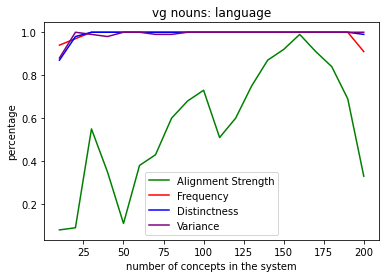

In [79]:
plot_percentage("vg nouns: language",aggregated_vg_noun_data,noun_aoa_sorted,10,noun_freq_dict,noun_language_distinctness,noun_language_variance,num_simulation=100,concept_all=True)

6.507066249847412
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


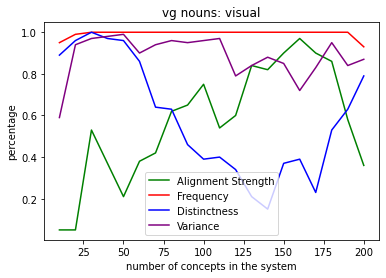

In [80]:
plot_percentage("vg nouns: visual",aggregated_vg_noun_data,noun_aoa_sorted,10,noun_freq_dict,noun_visual_distinctness,noun_visual_variance,num_simulation=100,concept_all=True)

6.4262800216674805
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


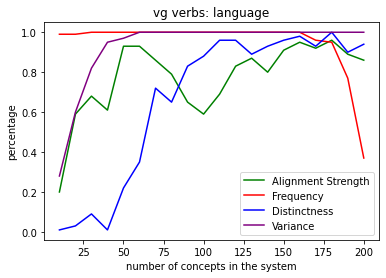

In [85]:
plot_percentage("vg verbs: language",aggregated_vg_verb_data,verb_aoa_sorted,10,verb_freq_dict,verb_language_distinctness,verb_language_variance,num_simulation=100,concept_all=True)

6.533416986465454
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


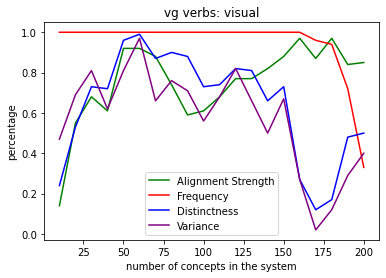

In [82]:
plot_percentage("vg verbs: visual",aggregated_vg_verb_data,verb_aoa_sorted,10,verb_freq_dict,verb_visual_distinctness,verb_visual_variance,num_simulation=100,concept_all=True)

7.553218841552734
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210]


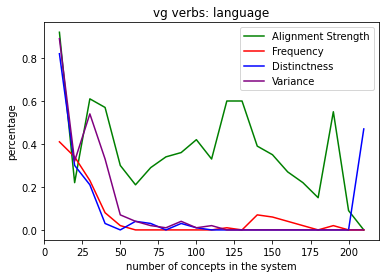

In [71]:
plot_percentage("vg verbs: language",aggregated_vg_verb_data,heaviness_sorted,10,verb_freq_dict,verb_language_distinctness,verb_language_variance,num_simulation=100,concept_all=True)

7.763331174850464
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210]


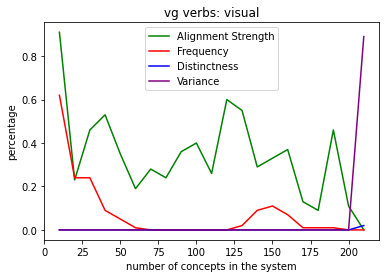

In [72]:
plot_percentage("vg verbs: visual",aggregated_vg_verb_data,heaviness_sorted,10,verb_freq_dict,verb_visual_distinctness,verb_visual_variance,num_simulation=100,concept_all=True)